In [3]:
!pip3 install yfinance 
!pip3 install fastcluster

     |████████████████████████████████| 6.4 MB 12.1 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 194 kB 29.0 MB/s 


In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [6]:
!unzip "/content/drive/MyDrive/corrgan/corrgan-models.zip" -d "/content/drive/MyDrive/corrgan/"

Archive:  /content/drive/MyDrive/corrgan/corrgan-models.zip
replace /content/drive/MyDrive/corrgan/corrgan-models/example_corrgan.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/corrgan/corrgan-models/example_corrgan.ipynb  
replace /content/drive/MyDrive/corrgan/corrgan-models/saved_model/generator_160d/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/corrgan/corrgan-models/saved_model/generator_160d/variables/variables.data-00000-of-00001  y
y
y
y
y


replace /content/drive/MyDrive/corrgan/corrgan-models/saved_model/generator_160d/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /content/drive/MyDrive/corrgan/corrgan-models/saved_model/generator_160d/variables/variables.index  
replace /content/drive/MyDrive/corrgan/corrgan-models/saved_model/generator_160d/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /content/drive/MyDrive/corrgan/

In [29]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from scipy.cluster import hierarchy
import fastcluster
from statsmodels.stats.correlation_tools import corr_nearest
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

# https://gmarti.gitlab.io/qfin/2020/08/11/corrgan-pretrained-models.html
def sample_from_corrgan(model_loc:str, dim:int, n_samples:int) -> np.ndarray:  
    pre_trained_generator = tf.keras.models.load_model(
        f"{model_loc}generator_{dim}d"
    )

    noise_dim = 100
    noise = tf.random.normal([n_samples, noise_dim])
    generated_image = pre_trained_generator(noise, training=False)

    a, b = np.triu_indices(dim, k=1)

    nearest_corr_matrices = []
    for i in tqdm(range(n_samples)):
        corr_matrix = np.array(generated_image[i, :, :, 0])
        # set diag to 1
        np.fill_diagonal(corr_matrix, 1)
        # symmetrize
        corr_matrix[b, a] = corr_matrix[a, b]
        # nearest corr
        nearest_corr_matrix = corr_nearest(corr_matrix)
        # set diag to 1
        np.fill_diagonal(nearest_corr_matrix, 1)
        # symmetrize
        nearest_corr_matrix[b, a] = nearest_corr_matrix[a, b]

        # arrange with hierarchical clustering
        dist = 1 - nearest_corr_matrix
        dim = len(dist)
        tri_a, tri_b = np.triu_indices(dim, k=1)
        Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
        ordered_corr = nearest_corr_matrix[permutation, :][:, permutation]

        nearest_corr_matrices.append(ordered_corr)

    return nearest_corr_matrices

dim, n_samples = 100, 4
nearest_corr_matrices = sample_from_corrgan("/content/drive/MyDrive/corrgan/corrgan-models/saved_model/", dim, n_samples)


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


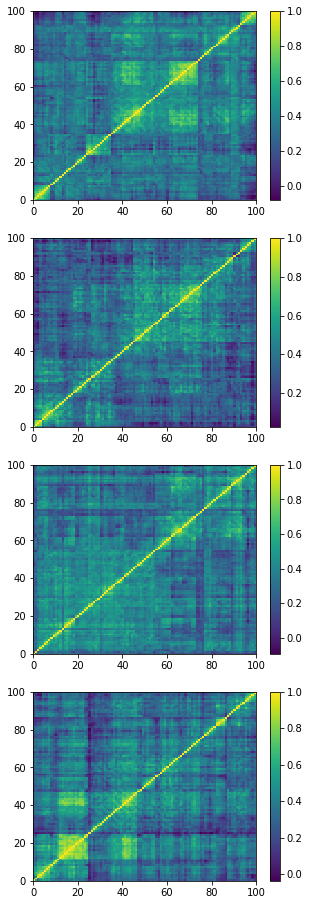

In [31]:
plt.figure(figsize=(5, 16))
for i in range(len(nearest_corr_matrices)):
    plt.subplot(4, 1, i + 1)
    plt.pcolormesh(nearest_corr_matrices[i][:, :], cmap='viridis')
    plt.colorbar()

plt.show()